## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib.patches import Arc, Rectangle, ConnectionPatch
import seaborn as sns
import os
import imageio
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
import ast

## Reading in Barcelona Data

From our previous notebook, we can import all the Barcelona games available in Statsbomb's open data

In [2]:
barca_allgames = pd.read_csv('../open-data/data/teams/Barcelona_data.csv')

//anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (22,28,32,33,34,36,39,40,43,44,63,64,65,68,70,71,72,73,74,76,88,89,91,92,94,96,98,101,114,115,116,120,123,124,125,126,127,128,129,131,137,138,139,140,141,143,144,146,147,148) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
barca_allgames['timestamp'] = pd.to_datetime(barca_allgames['timestamp'])

In [4]:
barca_allgames.shape

(874826, 149)

Due to constaints on time, we will narrow this down to only one game.

In [5]:
barca = barca_allgames.iloc[:6834,]

In [6]:
barca[barca['type_name']=='Starting XI']

,id,index,period,timestamp,minute,second,possession,duration,related_events,location,...,block_offensive,block_deflection,bad_behaviour_card_name,bad_behaviour_card_id,miscontrol_aerial_won,50_50_outcome_name,50_50_outcome_id,half_start_late_video_start,half_end_early_video_end,player_off_permanent
0,1f871f31-7a38-4e3d-a936-cf2397e921f7,1,1,2019-12-02,0,0,1,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,58cbfd8f-7f5d-4ca3-a0cc-e0610f2a2a14,2,1,2019-12-02,0,0,1,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
lineup = barca['tactics_lineup'][0]
lineup = ast.literal_eval(lineup)

In [8]:
list_players = []
for dictionary in lineup:
    list_players.append(dictionary['player']['name'])

In [9]:
list_players

['Marc-André ter Stegen',
 'Daniel Alves da Silva',
 'Gerard Piqué Bernabéu',
 'Javier Alejandro Mascherano',
 'Jordi Alba Ramos',
 'Sergio Busquets i Burgos',
 'Andrés Iniesta Luján',
 'Ivan Rakitić',
 'Lionel Andrés Messi Cuccittini',
 'Neymar da Silva Santos Junior',
 'Luis Alberto Suárez Díaz']

Lineup only for one game... need to get for every game as it changes with game 

## Cleaning Barcelona Data

We will first create a check list of columns I need to check. These are the columns that the warning above is mentioning. We should have done this in the first notebook but due to time constraints, we will only do it here. If there is time, I will address this problem in the previous notebook in order to prevent the same warning every time we import a particular team data csv file.

In [10]:
cols = list(barca.columns)
index_to_check = [22,28,32,33,34,36,39,40,43,44,63,
                  64,65,68,70,71,72,73,74,76,88,89,
                  91,92,94,96,98,101,114,115,116,120,
                  123,124,125,126,127,128,129,131,137,
                  138,139,140,141,143,144,146,147,148]

We will get the name of the columns that were referenced by the warning into a list called `mixed_cols`

In [11]:
mixed_cols = []
for index in index_to_check:
    mixed_cols.append(cols[index])

Lets take a look at what the columns look like:

In [12]:
barca[mixed_cols].T

,0,1,2,3,4,5,6,7,8,9,...,6824,6825,6826,6827,6828,6829,6830,6831,6832,6833
tactics_lineup,"[{'player': {'id': 20055, 'name': 'Marc-André ...","[{'player': {'id': 6792, 'name': 'Pau López Sa...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pass_deflected,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pass_aerial_won,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pass_no_touch,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pass_miscommunication,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pass_straight,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pass_cut_back,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pass_inswinging,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pass_outswinging,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pass_goal_assist,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
barca[barca['shot_deflected'].isna()== True]['shot_deflected'].value_counts()

Series([], Name: shot_deflected, dtype: int64)

In [14]:
barca[barca['shot_deflected'].isna()== False]['shot_deflected'].value_counts()

True    1
Name: shot_deflected, dtype: int64

After checking in with the data dictionary, we will narrow down our columns. We will not need any IDs except for the row `id` because every time there is an id for a specific column, there is also a name for that exact column. The redundance of information does not help. 

In [15]:
barca.drop(columns= barca.columns[barca.columns.str.contains('_id')], inplace = True)
barca

//anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,id,index,period,timestamp,minute,second,possession,duration,related_events,location,...,injury_stoppage_in_chain,block_save_block,block_offensive,block_deflection,bad_behaviour_card_name,miscontrol_aerial_won,50_50_outcome_name,half_start_late_video_start,half_end_early_video_end,player_off_permanent
0,1f871f31-7a38-4e3d-a936-cf2397e921f7,1,1,2019-12-02 00:00:00.000,0,0,1,0.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,58cbfd8f-7f5d-4ca3-a0cc-e0610f2a2a14,2,1,2019-12-02 00:00:00.000,0,0,1,0.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,b48b3dee-38d6-4682-93a9-5e06514d015c,3,1,2019-12-02 00:00:00.000,0,0,1,0.000000,['7d4e60fb-0dac-4a2f-b47a-f7237024cbc8'],NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,7d4e60fb-0dac-4a2f-b47a-f7237024cbc8,4,1,2019-12-02 00:00:00.000,0,0,1,0.000000,['b48b3dee-38d6-4682-93a9-5e06514d015c'],NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,e97ecc5e-c15f-47af-8d3b-32af0c55ef3a,9,1,2019-12-02 00:00:06.083,0,6,3,2.806400,"['7efa37aa-4772-45d4-812b-2bbf5e16f597', 'c485...","[56.1, 6.5]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6829,9996309c-9561-4b35-b950-990063fbdb62,3984,2,2019-12-02 00:48:11.821,93,11,209,0.794268,['6ed329e9-fed7-47cb-86e8-18f3aa88ccbb'],"[44.9, 72.2]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6830,9487c12f-8e67-4971-b295-d0344d16d459,3985,2,2019-12-02 00:48:13.055,93,13,209,0.000000,['3dfa8b26-f593-47bb-8cd5-cd3bbe82467e'],"[42.8, 66.8]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6831,3dfa8b26-f593-47bb-8cd5-cd3bbe82467e,3986,2,2019-12-02 00:48:13.055,93,13,209,0.000000,['9487c12f-8e67-4971-b295-d0344d16d459'],"[78.2, 14.2]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6832,d2544d8d-fc98-418a-9b1e-66c4f6c4af23,3987,2,2019-12-02 00:48:22.644,93,22,209,0.000000,['a122914c-dcda-4336-89d4-c1f0afba874a'],NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Now that we have remaining name columns, we can focus on imputing `NaN` values for each column. Since the expected values in this columns are string names, we will replace `NaN` values with the `'Not Applicable` in order for us to know that the row does not have any associated name to it. We will also remove the colums that were filled with `Not Applicable`, from our `mixed_cols` list if they exist in the list 

In [16]:
name_cols = list(barca.columns[barca.columns.str.contains('_name')])

In [17]:
for name in name_cols:
    barca[name].fillna('Not Applicable', inplace = True)
    if name in mixed_cols:
        mixed_cols.remove(name)
mixed_cols

//anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:6287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


['tactics_lineup',
 'pass_deflected',
 'pass_aerial_won',
 'pass_no_touch',
 'pass_miscommunication',
 'pass_straight',
 'pass_cut_back',
 'pass_inswinging',
 'pass_outswinging',
 'pass_goal_assist',
 'dribble_overrun',
 'dribble_nutmeg',
 'dribble_no_touch',
 'goalkeeper_success_in_play',
 'goalkeeper_success_out',
 'goalkeeper_shot_saved_to_post',
 'goalkeeper_punched_out',
 'goalkeeper_lost_out',
 'goalkeeper_lost_in_play',
 'goalkeeper_shot_saved_off_target',
 'shot_one_on_one',
 'shot_deflected',
 'shot_follows_dribble',
 'shot_open_goal',
 'shot_saved_to_post',
 'shot_aerial_won',
 'shot_redirect',
 'shot_saved_off_target',
 'ball_recovery_recovery_failure',
 'ball_recovery_offensive',
 'clearance_other',
 'clearance_aerial_won',
 'foul_won_penalty',
 'foul_won_advantage',
 'foul_won_defensive',
 'foul_committed_offensive',
 'foul_committed_penalty',
 'foul_committed_advantage',
 'injury_stoppage_in_chain',
 'block_save_block',
 'block_offensive',
 'block_deflection',
 'miscontro

We will remove `tactice_lineup` from our `mixed_cols` list since this is not a boolean column 

In [18]:
mixed_cols.remove('tactics_lineup')

Now that we have narrowed down our `mixed_cols` list to only boolean columns, we can replace any `NaN` values or empty strings with 0 and `True` with 1 

In [19]:
for col in mixed_cols:
    barca[col] = barca[col].map({True: 1, np.nan:0, '':0 })

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [20]:
remaining_cols = [col for col in  barca if len(barca[barca[col].isna()]) > 0]
remaining_cols

['duration',
 'related_events',
 'location',
 'under_pressure',
 'counterpress',
 'off_camera',
 'out',
 'tactics_lineup',
 'tactics_formation',
 'pass_switch',
 'pass_shot_assist',
 'pass_cross',
 'pass_length',
 'pass_through_ball',
 'pass_end_location',
 'pass_angle',
 'pass_backheel',
 'carry_end_location',
 'goalkeeper_end_location',
 'goalkeeper_penalty_saved_to_post',
 'goalkeeper_saved_to_post',
 'shot_statsbomb_xg',
 'shot_end_location',
 'shot_kick_off',
 'shot_freeze_frame',
 'shot_first_time',
 'clearance_left_foot',
 'clearance_head',
 'clearance_right_foot']

Notice that some of these columns, some of these columns are also boolean columns but were not part of the warnings in the import.

Lets tackle the boolean columns first since we know how to appraoch these columns from before

In [21]:
boolean_cols =[ 'under_pressure', 'counterpress', 'off_camera', 'out','pass_switch', 
                'pass_shot_assist', 'pass_cross', 'pass_backheel', 'goalkeeper_penalty_saved_to_post',
                'goalkeeper_saved_to_post','shot_first_time','shot_kick_off','shot_freeze_frame',
                'clearance_left_foot','clearance_right_foot','clearance_head' ]
for col in boolean_cols:
    barca[col] = barca[col].map({True: 1, np.nan:0, '':0 })
    if col in remaining_cols:
        remaining_cols.remove(col)

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [22]:
remaining_cols

['duration',
 'related_events',
 'location',
 'tactics_lineup',
 'tactics_formation',
 'pass_length',
 'pass_through_ball',
 'pass_end_location',
 'pass_angle',
 'carry_end_location',
 'goalkeeper_end_location',
 'shot_statsbomb_xg',
 'shot_end_location']

According to out data dictionary, `through_ball` variable for passes is now depracted so we will remove them from our dataframe

In [23]:
barca.drop(columns= ['pass_through_ball'], inplace = True)
remaining_cols.remove('pass_through_ball')
remaining_cols

['duration',
 'related_events',
 'location',
 'tactics_lineup',
 'tactics_formation',
 'pass_length',
 'pass_end_location',
 'pass_angle',
 'carry_end_location',
 'goalkeeper_end_location',
 'shot_statsbomb_xg',
 'shot_end_location']

Another group of columns found are location columns. They all have similar problems so lets tackle them all at once

In [24]:
loc_col = []
for name in remaining_cols:
    if 'location' in name:
        loc_col.append(name)

For every location column, we will impute `NaN` values to `'[-1,-1]'` and remove them from `remaining_cols` to check

In [25]:
for loc in loc_col:
    barca[loc].fillna('[-1,-1]', inplace = True)
    if loc in remaining_cols:
        remaining_cols.remove(loc)

For the time beaing, everything else will be assigned to 0 if there is a null value. I am short on time but will review this when I have more time

In [26]:
for col in remaining_cols:
    barca[col] = barca[col].map({ np.nan:0, '':0 })

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## Adjusting Coordinates

In order to plot location data, we will need to make new columns in order to have x and y coordinates separated 

In [27]:
x = []
y = []
for row in barca['location']:
    x.append(row.split(',')[0].strip('['))
    y.append(row.split(',')[1].strip(']'))

In [28]:
barca['x_coordinates'] = x
barca['y_coordinates'] = y

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [29]:
barca[['x_coordinates', 'y_coordinates', 'location']]

,x_coordinates,y_coordinates,location
0,-1,-1,"[-1,-1]"
1,-1,-1,"[-1,-1]"
2,-1,-1,"[-1,-1]"
3,-1,-1,"[-1,-1]"
4,56.1,6.5,"[56.1, 6.5]"
...,...,...,...
6829,44.9,72.2,"[44.9, 72.2]"
6830,42.8,66.8,"[42.8, 66.8]"
6831,78.2,14.2,"[78.2, 14.2]"
6832,-1,-1,"[-1,-1]"


We will need to adjust the x and y coordinates since the coordinates provided are not in the same quadrant as a normal graph. Or else every time we want to interpret our visuals, we would have to remember that our images are inverted!!!  

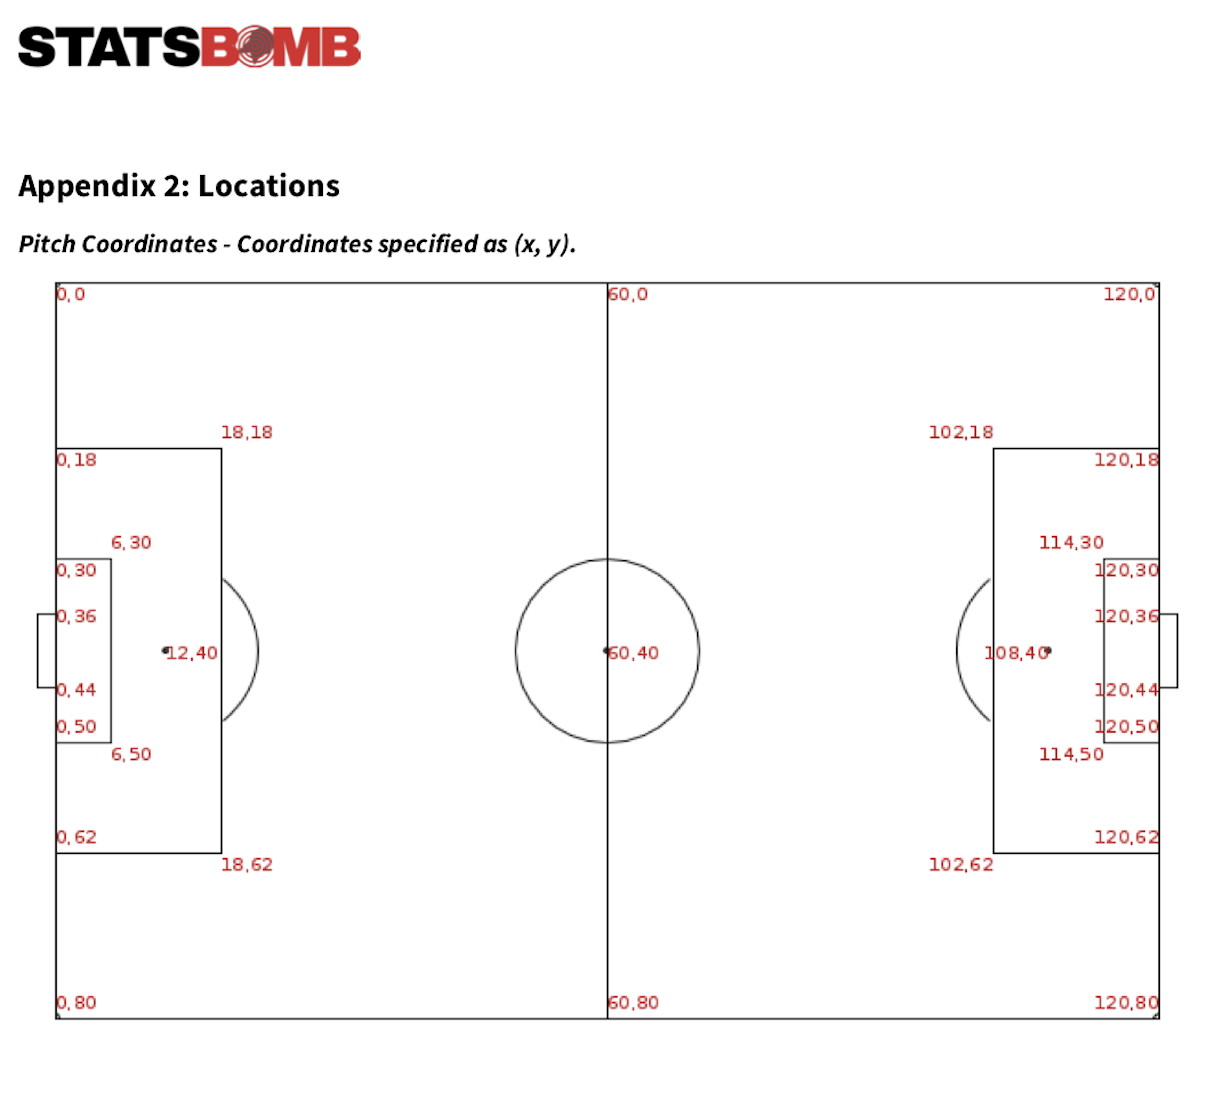


Converting coordinates to floats since they were read in as strings

In [30]:
barca['y_coordinates'] = barca['y_coordinates'].astype(float)
barca['x_coordinates'] = barca['x_coordinates'].astype(float)

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Adjusting values for y-axis

In [31]:
def invert_coor(val):
    return 80 - val

In [32]:
barca['y_coordinates'] = barca['y_coordinates'].apply(invert_coor)

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


No need to modify `x_coordinates` because they are ready to go

## Visualization

We will be creating heatmaps for Barcelona's players throughout this game

In [33]:
#CREDIT TO GITHUB USERNAME: tuangauss 
#for creating a function to generate a soccer_pitch 
#https://github.com/tuangauss/DataScienceProjects/blob/master/Python/football_visual.ipynb

def draw_pitch(ax):
    # size of the pitch is 120, 80
    #Create figure

    #Pitch Outline & Centre Line
    plt.plot([0,0],[0,80], color="black")
    plt.plot([0,120],[80,80], color="black")
    plt.plot([120,120],[80,0], color="black")
    plt.plot([120,0],[0,0], color="black")
    plt.plot([60,60],[0,80], color="black")

    #Left Penalty Area
    plt.plot([14.6,14.6],[57.8,22.2],color="black")
    plt.plot([0,14.6],[57.8,57.8],color="black")
    plt.plot([0,14.6],[22.2,22.2],color="black")

    #Right Penalty Area
    plt.plot([120,105.4],[57.8,57.8],color="black")
    plt.plot([105.4,105.4],[57.8,22.5],color="black")
    plt.plot([120, 105.4],[22.5,22.5],color="black")

    #Left 6-yard Box
    plt.plot([0,4.9],[48,48],color="black")
    plt.plot([4.9,4.9],[48,32],color="black")
    plt.plot([0,4.9],[32,32],color="black")

    #Right 6-yard Box
    plt.plot([120,115.1],[48,48],color="black")
    plt.plot([115.1,115.1],[48,32],color="black")
    plt.plot([120,115.1],[32,32],color="black")

    #Prepare Circles
    centreCircle = plt.Circle((60,40),8.1,color="black",fill=False)
    centreSpot = plt.Circle((60,40),0.71,color="black", alpha= .3)
    leftPenSpot = plt.Circle((9.7,40),0.71,color="black")
    rightPenSpot = plt.Circle((110.3,40),0.71,color="black")

    #Draw Circles
    ax.add_patch(centreCircle)
    ax.add_patch(centreSpot)
    ax.add_patch(leftPenSpot)
    ax.add_patch(rightPenSpot)

    #Prepare Arcs
    # arguments for arc
    # x, y coordinate of centerpoint of arc
    # width, height as arc might not be circle, but oval
    # angle: degree of rotation of the shape, anti-clockwise
    # theta1, theta2, start and end location of arc in degree
    leftArc = Arc((9.7,40),height=16.2,width=16.2,angle=0,theta1=310,theta2=50,color="black")
    rightArc = Arc((110.3,40),height=16.2,width=16.2,angle=0,theta1=130,theta2=230,color="black")

    #Draw Arcs
    ax.add_patch(leftArc)
    ax.add_patch(rightArc)

In [34]:
def player_tracking_plot(player_name, df, mins = 90):
    #Making folder for player heatmaps 
    try:
        os.mkdir('../open-data/data/Player_Heatmaps/'+player_name)
    except:
        print(f'{player_name} directory already exists')
        
    for minute in range(0, mins-4, 5):
        
        #Dimensions of plots
        fig, ax1 = plt.subplots(1, 1)
        fig.set_figheight(8)
        fig.set_figwidth(12)

        #Drawing Field
        draw_pitch(ax1) 

        #Applying conditions
        plt.ylim(0, 80)
        plt.xlim(0, 120)
        plt.axis('off')
        
        player_df = df[(df['player_name']== player_name) & ((df['minute'] >= minute) & (df['minute'] <= minute + 5))]
        if len(player_df) > 2:
            #Heatmap
            sns.kdeplot(player_df['x_coordinates'],
                        player_df['y_coordinates'],
                        shade = "True", n_levels = 35, color = 'green')
        else:
            #Scatterplot if not enough data
            sns.scatterplot(player_df['x_coordinates'],
                            player_df['y_coordinates'],
                            color = 'green')

        #Cosmetic Additions
        plt.title(f'{player_name} Movements', size = 35)
        plt.legend(labels= [f'Minute: {minute+5}'], 
                   loc='center left', 
                   bbox_to_anchor=(.375, -.05), 
                   handlelength=0, 
                   fontsize= 20)


        #Save Heatmap
        if minute <10:
            plt.savefig(f'../open-data/data/Player_Heatmaps/{player_name}/{player_name}_0{minute}to{minute+5}.png')
        else:
            plt.savefig(f'../open-data/data/Player_Heatmaps/{player_name}/{player_name}_{minute}to{minute+5}.png')
        plt.close(fig)


In [35]:
def make_gif(name):
    png_dir = f'../open-data/data/Player_Heatmaps/{name}'
    image_order = []
    dir_list = os.listdir(png_dir)
    dir_list.sort()
    for file_name in dir_list:
        file_path = os.path.join(png_dir, file_name)
        image_order.append(imageio.imread(file_path))
    imageio.mimsave(f'../open-data/data/Player_GIFs/{name}.gif', image_order, fps = 1)

In [36]:
for player in list_players:
    player_tracking_plot(player, barca)
    make_gif(player)

Marc-André ter Stegen directory already exists


//anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kernels.py:128: RuntimeWarning: divide by zero encountered in true_divide
  return (1. / np.sqrt(2 * np.pi)) * np.exp(-(Xi - x)**2 / (h**2 * 2.))
//anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kernels.py:128: RuntimeWarning: invalid value encountered in true_divide
  return (1. / np.sqrt(2 * np.pi)) * np.exp(-(Xi - x)**2 / (h**2 * 2.))
//anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/_kernel_base.py:516: RuntimeWarning: invalid value encountered in true_divide
  dens = Kval.prod(axis=1) / np.prod(bw[iscontinuous])
//anaconda3/lib/python3.7/site-packages/matplotlib/contour.py:1557: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
//anaconda3/lib/python3.7/site-packages/matplotlib/contour.py:1558: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
//anaconda3/lib/python3.7/site-packages/matplotlib/contour.py:1203: 

Daniel Alves da Silva directory already exists
Gerard Piqué Bernabéu directory already exists
Javier Alejandro Mascherano directory already exists
Jordi Alba Ramos directory already exists
Sergio Busquets i Burgos directory already exists
Andrés Iniesta Luján directory already exists
Ivan Rakitić directory already exists
Lionel Andrés Messi Cuccittini directory already exists
Neymar da Silva Santos Junior directory already exists
Luis Alberto Suárez Díaz directory already exists


In [95]:
def pass_outcome_plot(df, outcome = 'Incomplete', period = 1, color = 'black'):
    #Making folder for outcomes heatmaps 
    try:
        os.mkdir(f'../open-data/data/Player_Heatmaps/{outcome}')
    except:
        print(f'{outcome} directory already exists')

    #Dimensions of plots
    fig, ax1 = plt.subplots(1, 1)
    fig.set_figheight(8)
    fig.set_figwidth(12)

    #Drawing Field
    draw_pitch(ax1) 

    #Applying conditions
    plt.ylim(0, 80)
    plt.xlim(0, 120)
    plt.axis('off') 


    outcome_df = df[(df['pass_outcome_name'] == outcome) & (df['period'] == period) ]

    sns.kdeplot(outcome_df['x_coordinates'], outcome_df['y_coordinates'],
            shade = "True", n_levels = 30, color = color)
    #Cosmetic Additions
    if period == 1:
        plt.title(f'{outcome} Passes at Half-Time', size = 35)
    else:
        plt.title(f'{outcome} Passes Beginning at Half-Time', size = 35)

    #Cosmetics
    plt.legend(labels= [f'Pass: {outcome}'], 
               loc='center left', 
               bbox_to_anchor=(.375, -.05), 
               handlelength=0, 
               fontsize= 20)
    
    #Save Heatmap
        
    plt.savefig(f'../open-data/data/Passes_Heatmaps/{outcome}_{period}.png')    
    plt.close(fig)

In [ ]:
pass_outcome_plot(barca, outcome = 'Incomplete', period = 1, color = 'black')

## Recommendations and Conclusions